In [1]:
dataset_root = "../dataset/"
images_dir = dataset_root + "complete/"
features_dir = dataset_root + 'handcrafted/'

recompute_features = False
classify_images = False

In [2]:
import sys
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import numpy as np
sys.path.append("..")

from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from feature_extraction import build_feature_extractor, cut_layer_of_model, unroll_layers
from similarity_search.neural_similarity_search import extract_features, filter_images_not_in_same_class
from handcrafted_extraction import load_all_features, load_features
import pandas as pd

extracted_features_root = "./extracted_features/"
extracted_features_path = extracted_features_root + 'efficient_net_similarity'
filenames_path = extracted_features_root + 'efficient_net_similarity_filenames.csv'
predictions_path = extracted_features_root + 'predictions.pickle'

model = keras.models.load_model('../classification/tuned_models/efficientnet_v2_cosine')

def builder():
    model = keras.models.load_model('../classification/tuned_models/efficientnet_v2_cosine')
    return keras.Sequential(model.layers[:-1])
    #return build_feature_extractor(EfficientNetV2B0, 'top_dropout')

predictions = pd.read_pickle(predictions_path)

2024-01-08 14:58:21.325845: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 14:58:21.327648: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 14:58:21.352747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 14:58:21.352772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 14:58:21.353433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
(handcrafted_features, _) = load_all_features(features_dir, os.listdir(images_dir), load_color=True, load_lbp=True, load_gabor=False, load_sift=False, load_bow=False)

100%|██████████| 130469/130469 [00:03<00:00, 35302.53it/s]


In [4]:
extracted_features = np.load(extracted_features_path + '.npy')
filenames = pd.read_csv(filenames_path, header=None).iloc[:, 1].values
files = os.listdir(images_dir);

## Similar images

In [5]:
## settings
use_nn = True
use_intersection = False
intersect_with_classes = True
images_to_consider = 1000

In [6]:
from similarity_search.neural_similarity_search import find_similar, find_similar_handcrafted

def compute_most_similar(query_path):
    nn_most_similar, distances = find_similar(builder(), query_path, extracted_features, filenames, preprocess_input, output_number=images_to_consider)
    handcrafted_most_similar, distances = find_similar_handcrafted(images_dir, handcrafted_features, query_path, False, output_number=images_to_consider)

    intersection = np.intersect1d(handcrafted_most_similar, nn_most_similar)
    print('Images on which handcrafted and nn agree: ', len(intersection), 'over', images_to_consider)

    most_similar_filenames = nn_most_similar if use_nn else handcrafted_most_similar
    most_similar_filenames = intersection if use_intersection else most_similar_filenames

    if intersect_with_classes:
        most_similar_filenames = filter_images_not_in_same_class(predictions, model, preprocess_input, str(query_path), most_similar_filenames, 0.7)

    return most_similar_filenames


## Query image
(the visualized image is used in the search phase)

1/1 [==============================] - 1s 917ms/step
Images on which handcrafted and nn agree:  15 over 1000


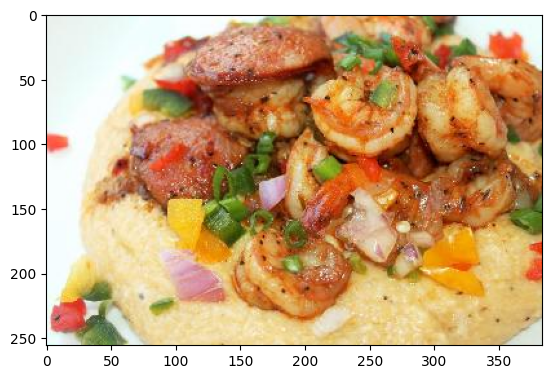

In [18]:
index = np.random.randint(len(files), size=1)[0]
query_path = images_dir + files[index]

query_img = cv.imread(query_path)
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB);

plt.imshow(query_img);
similar_index = 0;
most_similar_filenames = compute_most_similar(query_path)

## iterate over one image at step

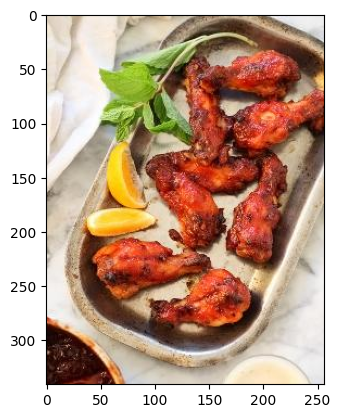

In [23]:
img = cv.imread(images_dir + most_similar_filenames[similar_index])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

plt.imshow(img)
similar_index += 1

## create collage

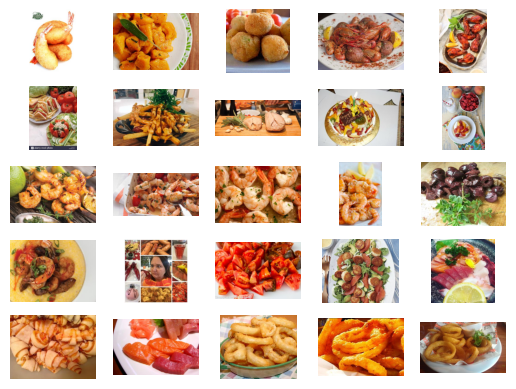

In [24]:
from misc import create_collage_with_random_imgs

create_collage_with_random_imgs(images_dir, None, 5, most_similar_filenames, False)